In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as keras
from keras import backend as K
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score
from functools import partial
from keras.callbacks import *
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import loadmat, savemat
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_rel,ttest_1samp
from numpy.ma import masked_array

import innvestigate as inn
import innvestigate.utils

Using TensorFlow backend.


In [2]:
# Load Data

filepath = ['C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/segmented_hc1_data_v2.npy',
            'C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/segmented_hc2_data_v2.npy',
            'C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/segmented_mdd1_data_v2.npy',
            'C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/segmented_mdd2_data_v2.npy']

for i in np.arange(4):

    f = np.load(filepath[i],allow_pickle=True).item()
    
    if i == 0:
        data = f['data']
        labels = f['label']
        groups = f['subject']
    else:
        data = np.concatenate((data,f['data']),axis=0)
        labels = np.concatenate((labels,f['label']),axis=0)
        groups = np.concatenate((groups,f['subject']),axis=0)
        channels = f['channels']
        

channels2 = []
for i in range(19):
    channels2.append(channels[i].strip('EEG ').strip('-L'))

channels = channels2
channels2 = []

data = np.swapaxes(data,1,2)

In [3]:
## Define Model

def get_model(dropout=0.5):
    
    n_timesteps = 5000
    n_features = 19

    convLayer = partial(keras.layers.convolutional.Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=keras.constraints.max_norm(max_value = 1))
    
    model = keras.models.Sequential()
    model.add(convLayer(5, kernel_size=10, strides=1, input_shape=(n_timesteps, n_features), data_format='channels_last'))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(keras.layers.BatchNormalization())

    model.add(convLayer(10, kernel_size=10, strides=1))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(keras.layers.BatchNormalization())
    
    model.add(convLayer(10, kernel_size=10, strides=1))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(keras.layers.BatchNormalization())
    
    model.add(convLayer(15, kernel_size=5, strides=1))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.AlphaDropout(rate= dropout))
    
    model.add(keras.layers.Dense(64, activation='elu', kernel_initializer='he_normal', kernel_constraint=keras.constraints.max_norm(max_value = 1),name = "dense_l1"))
    model.add(keras.layers.AlphaDropout(rate= dropout))
    model.add(keras.layers.Dense(32, activation='elu', kernel_initializer='he_normal', kernel_constraint=keras.constraints.max_norm(max_value = 1),name="dense_l2"))
    model.add(keras.layers.AlphaDropout(rate= dropout))
    model.add(keras.layers.Dense(2, activation='softmax', kernel_initializer='glorot_normal', kernel_constraint=keras.constraints.max_norm(max_value = 1),name="dense_output"))

    return model

In [5]:
tf.random.set_random_seed(49) # best is seed 42, v7


# will need to uncomment everything in this cell for initial training
testing_metrics = []

n_timesteps = 5000
n_features = 19

i = 0

val_loss = []; train_loss = [];
val_acc = []; train_acc = [];

gss = GroupShuffleSplit(n_splits = 10, train_size = 0.9, random_state = 12) 

for tv_idx, test_idx in gss.split(data, labels, groups):
    
    print(i)
    tf.keras.backend.clear_session()

    X_train_val = data[tv_idx]
    y_train_val = labels[tv_idx]

    X_test = data[test_idx]
    y_test = labels[test_idx]

    group = groups[tv_idx]
    gss_train_val = GroupShuffleSplit(n_splits = 1, train_size = 0.83, random_state = 12)
    for train_idx, val_idx in gss_train_val.split(X_train_val, y_train_val, group):
        
        X_train = X_train_val[train_idx]
        y_train = y_train_val[train_idx]
        
        X_val = X_train_val[val_idx]
        y_val = y_train_val[val_idx]

        # Training Data Augmentation
        X_train = np.vstack((X_train, X_train + np.random.normal(loc=0, scale=0.7, size=X_train.shape)))
        y_train = np.hstack((y_train, y_train))
        
        K.clear_session()
        model = get_model()
        
        model.compile(optimizer=keras.optimizers.Adam(0.00075), loss='categorical_crossentropy',
                     metrics = ['acc'])

        file_path = "C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Models/model_v8_fold"+str(i)+".hdf5"

        early_stopping = keras.callbacks.EarlyStopping(monitor="val_acc",min_delta=0,patience=10)
        checkpoint = keras.callbacks.ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

        # Create Weights for Model Classes
        values, counts = np.unique(y_train, return_counts=True)

        weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = np.squeeze(y_train))
        class_weights = dict(zip(values, weights))
        
        history = model.fit(X_train, keras.utils.to_categorical(y_train), epochs= 35, batch_size = 128, validation_data=(X_val, keras.utils.to_categorical(y_val)), 
                            shuffle=True, verbose = 2, callbacks=[checkpoint,early_stopping],class_weight=class_weights)
        
        val_loss.append(history.history['val_loss']); train_loss.append(history.history['loss'])
        val_acc.append(history.history['val_acc']); train_acc.append(history.history['acc']);
        
        model.load_weights(file_path)

        preds = np.argmax(model.predict(X_test, batch_size=128),axis=1)

        testing_metrics.append([accuracy_score(y_test, preds),recall_score(y_test, preds, pos_label=1),recall_score(y_test, preds, pos_label=0),balanced_accuracy_score(y_test, preds)])
    
    i += 1



0













1
2
3
4
5
6
7
8
9


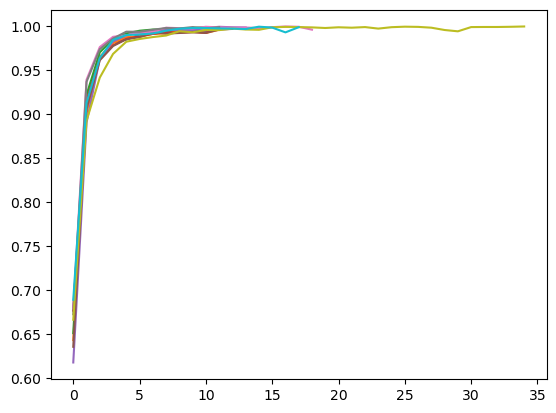

In [20]:
# Plot Training Performance
plt.figure()
for i in range(10):
    plt.plot(train_acc[i])

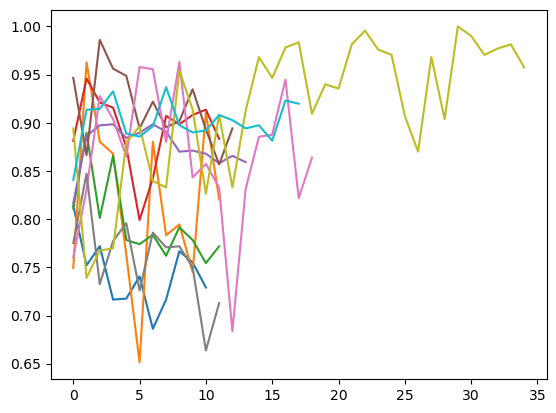

In [21]:
# Plot Validation Performance
plt.figure()
for i in range(10):
    plt.plot(val_acc[i])

In [12]:
print("Test Set Metrics") # with updated O2, v8
testing_metrics = np.array(testing_metrics)
print(testing_metrics)
print(pd.DataFrame(data=[testing_metrics.mean(axis=0), testing_metrics.std(axis=0)], index=['mean','std'], columns=['acc','sens','spec','bacc']))

Test Set Metrics
[[1.         1.         1.         1.        ]
 [0.80629139 1.         0.71182266 0.85591133]
 [0.72058824 0.83333333 0.53846154 0.68589744]
 [0.81107492 0.77254902 1.         0.88627451]
 [0.95833333 0.91826923 0.97836538 0.94831731]
 [0.83753943 1.         0.76376147 0.88188073]
 [0.81335616 0.9822695  0.65562914 0.81894932]
 [0.82363014 1.         0.66987179 0.8349359 ]
 [0.91042345 0.88916256 0.95192308 0.92054282]
 [0.81891026 0.63782051 1.         0.81891026]]
           acc      sens      spec      bacc
mean  0.850015  0.903340  0.826984  0.865162
std   0.078243  0.116848  0.168191  0.081424


# Get Model for Explainability

In [4]:
tf.random.set_random_seed(49) # best is seed 42, v7


testing_metrics = []

n_timesteps = 5000
n_features = 19

i = 0

gss = GroupShuffleSplit(n_splits = 10, train_size = 0.9, random_state = 12) 

for tv_idx, test_idx in gss.split(data, labels, groups):
    
    print(i)
    if i == 0: # fold 0 is top for model
        tf.keras.backend.clear_session()

        X_test = data[test_idx]
        y_test = labels[test_idx]
        
        K.clear_session()
        model = get_model()

        file_path = "C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Models/model_v8_fold"+str(i)+".hdf5" # original results in paper were for model v5
        
        model.load_weights(file_path)

        preds = np.argmax(model.predict(X_test, batch_size=128),axis=1)

        testing_metrics.append([accuracy_score(y_test, preds),recall_score(y_test, preds, pos_label=1),recall_score(y_test, preds, pos_label=0),balanced_accuracy_score(y_test, preds)])
    
    i += 1



0













1
2
3
4
5
6
7
8
9


In [5]:
# Check that model performance aligns with earlier results
testing_metrics

[[1.0, 1.0, 1.0, 1.0]]

# Explainability

In [8]:
#LRP Alpha-Beta Rule Implementation - Sums Relevance over Channel Dimension
def LRP_Output_ab(model,data,class_labels):
    #Strip softmax layer
    model_lrp = innvestigate.utils.model_wo_softmax(model)

    Rel_out = []
    analyzer = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model_lrp,neuron_selection_mode="index")
    Rel_ep = []
    for j in range(np.shape(data)[0]):
        x = data[j,:,:]
        a = analyzer.analyze(x[None], neuron_selection = class_labels[j])
        # get total percent of relevance for each feature
        a = np.sum(np.squeeze(100*np.abs(a)/np.sum(np.abs(a)))[None],axis=1) 
        if j == 0:
            Rel_out = a
        else:
            Rel_out = np.vstack((Rel_out,a))
        
    return(Rel_out)

In [9]:
freq_bands = [r'$\delta$',r'$\theta$',r'$\alpha$',r'$\beta$',r'$\gamma_{low}$',r'$\gamma_{high}$']
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

## Channel Importance

In [19]:
initial_rel,initial_rel_t, initial_rel_p = LRP_Channel_Importance(model,X_test,y_test)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:252: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


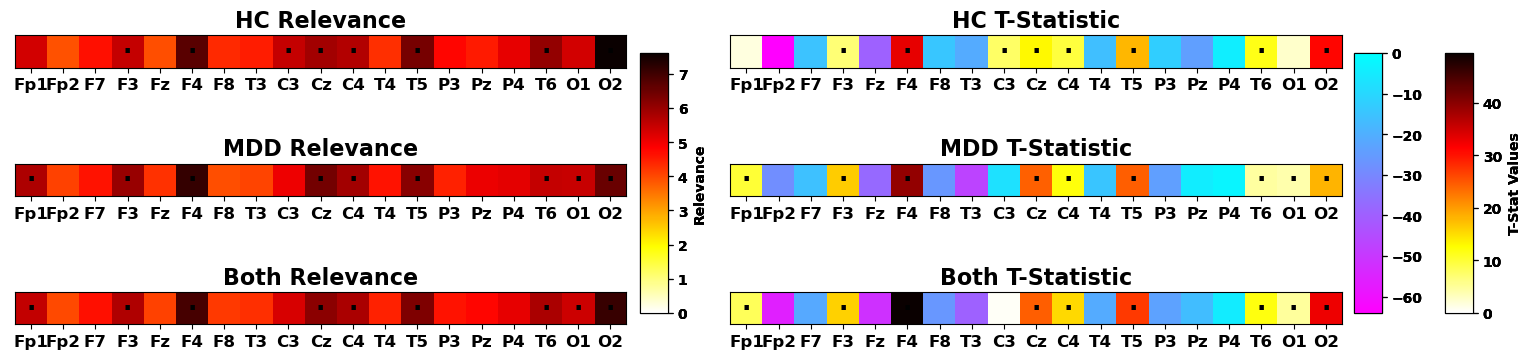

In [20]:
classes = ['HC','MDD','Both']
fig,ax = plt.subplots(3,2,figsize=(14,4))
fig.tight_layout()
for class_idx in range(3):
    
    im1 = ax[class_idx,0].imshow(initial_rel[class_idx,...].T[None],'hot_r',interpolation='nearest',vmin=0,vmax=np.max(initial_rel),alpha=1)# Reds_r
    ax[class_idx,0].set_title(classes[class_idx] + ' Relevance',weight='bold',fontsize=16)
    ax[class_idx,0].set_yticks([])
    ax[class_idx,0].set_xticks(np.arange(19))
    ax[class_idx,0].set_xticklabels(channels,weight='bold',fontsize=12)
 
    cbar_ax1 = fig.add_axes([.48, 0.19, 0.02, 0.65]) # left bottom width height
    cb1 = fig.colorbar(im1, cax=cbar_ax1);
    cb1.set_label(label='Relevance',weight='bold')
    plt.setp(cb1.ax.get_yticklabels(),weight='bold');
    
    vals_neg = masked_array(initial_rel_t[class_idx,...].T,initial_rel_t[class_idx,...].T>np.zeros_like(initial_rel_t[class_idx,...].T))
    vals_pos = masked_array(initial_rel_t[class_idx,...].T,initial_rel_t[class_idx,...].T<np.zeros_like(initial_rel_t[class_idx,...].T))
    im3 = ax[class_idx,1].imshow(vals_neg[None],'cool_r',interpolation='nearest',vmin=np.min(initial_rel_t),vmax=0,alpha=1)# Reds_r
    im4 = ax[class_idx,1].imshow(vals_pos[None],'hot_r',vmin=0,interpolation='nearest',vmax=np.max(initial_rel_t),alpha=1)# Reds_r
    ax[class_idx,1].set_title(classes[class_idx] + ' T-Statistic',weight='bold',fontsize=16)
    ax[class_idx,1].set_yticks([])
    ax[class_idx,1].set_xticks(np.arange(19))
    ax[class_idx,1].set_xticklabels(channels,weight='bold',fontsize=12)
 
    cbar_ax3 = fig.add_axes([0.99, 0.19, 0.02, 0.65]) # left bottom width height
    cbar_ax4 = fig.add_axes([1.055, 0.19, 0.02, 0.65]) # left bottom width height
    cb3 = fig.colorbar(im3, cax=cbar_ax3);
    cb4 = fig.colorbar(im4, cax=cbar_ax4);
    cb4.set_label(label='T-Stat Values',weight='bold')
    plt.setp(cb3.ax.get_yticklabels(),weight='bold');
    plt.setp(cb4.ax.get_yticklabels(),weight='bold');
    plt.subplots_adjust(wspace=.17)
    
    corrected_p_values = fdrcorrection(initial_rel_p[class_idx,...],alpha=0.001)[1]
    
    for i in range(19):
            if corrected_p_values[i] < 0.001 and initial_rel_t[class_idx,i] > 0:
                ax[class_idx,0].text(i,0-0.2,'.',color='k',ha='center',va='center',weight='bold',fontsize=18)
                ax[class_idx,1].text(i,0-0.2,'.',color='k',ha='center',va='center',weight='bold',fontsize=18)

fig.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Figure4 - Spatial Importance Plots v3.jpg",dpi=800, bbox_inches='tight')

In [18]:
from numpy import shape, zeros, zeros_like, ones_like, logical_and, squeeze
def LRP_Channel_Importance(model,X,Y):
    
    initial_rel = LRP_Output_ab(model,X,Y)
            
    initial_rel2 = np.zeros((3,19)) # initial_rel
    initial_rel_t = np.zeros((3,19))
    initial_rel_p = np.zeros((3,19))
    for class_idx in range(3): # iterate over classes (HC = 0, MDD = 1, Both = 2)
        class_ids = np.squeeze(Y == class_idx*np.ones_like(Y))
        initial_rel2[class_idx,:] = np.mean(initial_rel[class_ids,:],axis=0)
        initial_rel_t[class_idx,:], initial_rel_p[class_idx,:] = ttest_1samp(initial_rel[class_ids,:],100/19,axis=0,nan_policy='omit')
        if class_idx == 2:
            initial_rel2[class_idx,:] = np.mean(initial_rel,axis=0)
            initial_rel_t[class_idx,:], initial_rel_p[class_idx,:] = ttest_1samp(initial_rel,100/19,axis=0,nan_policy='omit')

            
    return (initial_rel2,initial_rel_t, initial_rel_p)

## Channel Interaction

In [22]:
initial_rel, rel_diff_channels, rel_pct_diff_channels, rel_diff_p_channels, rel_diff_t_channels = LRP_Perturbation_Channel_Interaction(model,X_test,y_test)

# Save Results
savemat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Interactions_All_Classes_Fold0_v8.npy',{'intial_rel':initial_rel,'rel_diff_channels':rel_diff_channels,'rel_pct_diff_channels':rel_pct_diff_channels,'rel_diff_p_channels':rel_diff_p_channels,'rel_diff_t_channels':rel_diff_t_channels})

C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 6


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 7


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 8


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 9


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 10


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 11


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 12


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 13


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 14


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 15


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 16


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 17
Channel 18


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [23]:
# Load Results
filepath = 'C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Interactions_All_Classes_Fold0_v8.npy'
intial_rel = np.squeeze(loadmat(filepath)['intial_rel']) # original relevance
rel_diff_channels = np.squeeze(loadmat(filepath)['rel_diff_channels']) # difference between original relevance and relevance after perturbation
rel_pct_diff_channels = np.squeeze(loadmat(filepath)['rel_pct_diff_channels']) # percent change in relevance
rel_diff_p_channels = np.squeeze(loadmat(filepath)['rel_diff_p_channels']) # two-tailed, paired t-test p-values
rel_diff_t_channels = np.squeeze(loadmat(filepath)['rel_diff_t_channels']) # two-tailed, paired t-statistics p-values

In [24]:
# Zero Out Values Along Left-to-Right Diagonal
for i in np.arange(19):
    for j in np.arange(19):
        if i == j:
            rel_diff_channels[:,i,j] = np.zeros((3,))
            rel_pct_diff_channels[:,i,j] = np.zeros((3,))
            rel_diff_t_channels[:,i,j] = np.zeros((3,))

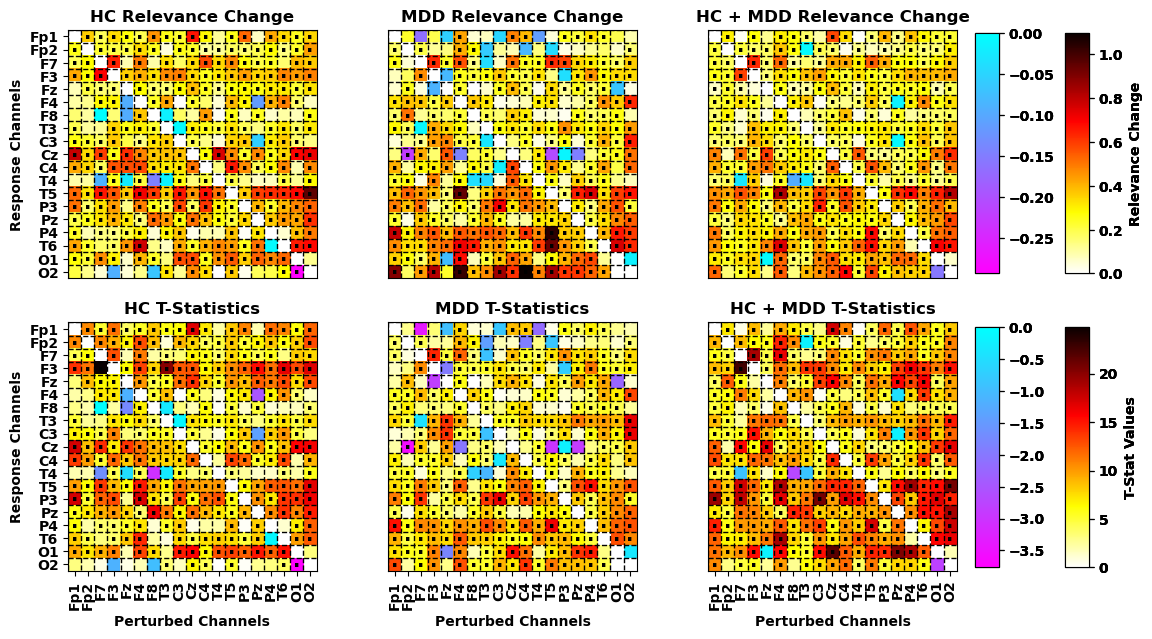

In [25]:
# Plot Negative Changes
class_val = ['HC','MDD','HC + MDD']
fig,ax = plt.subplots(2,3,figsize=(12,6))#,gridspec_kw={'height_ratios': [1,2,2]})
fig.tight_layout()
for class_idx in range(3): #(HC = 0, MDD = 1, Both = 2)
    
    vals_neg = masked_array(rel_diff_channels[class_idx,...].T,rel_diff_channels[class_idx,...].T>np.zeros_like(rel_diff_channels[class_idx,...].T))
    vals_pos = masked_array(rel_diff_channels[class_idx,...].T,rel_diff_channels[class_idx,...].T<np.zeros_like(rel_diff_channels[class_idx,...].T))
    im1 = ax[0,class_idx].imshow(vals_neg,'cool_r',interpolation='nearest',vmin=np.min(rel_diff_channels),vmax=0,alpha=1)# Reds_r
    im2 = ax[0,class_idx].imshow(vals_pos,'hot_r',vmin=0,interpolation='nearest',vmax=np.max(rel_diff_channels),alpha=1)# Reds_r
    
#     im2 = ax[0,class_idx].imshow(rel_diff_channels[class_idx,...].copy().T,'Reds_r',vmin = min_val,vmax = 0)
    ax[0,class_idx].set_title(class_val[class_idx] + ' Relevance Change',weight='bold')
    if class_idx == 0:
        ax[0,class_idx].set_yticks(np.arange(19));
        ax[0,class_idx].set_yticklabels(channels,fontsize=10,weight='bold');
        ax[0,class_idx].set_ylabel("Response Channels",weight='bold');
    else:
        ax[0,class_idx].set_yticks([]);
        ax[0,class_idx].set_yticklabels([]);
    ax[0,class_idx].set_xticks([])
    ax[0,class_idx].hlines(np.arange(19)-0.5,-0.5,18.5,'k','--',linewidth=1);
    ax[0,class_idx].vlines(np.arange(19)-0.5,-0.5,18.5,'k','--',linewidth=1);

    fig.subplots_adjust(right=0.8)
    cbar_ax1 = fig.add_axes([0.805, 0.56, 0.02, 0.40]) # left bottom width height
    cbar_ax2 = fig.add_axes([0.88, 0.56, 0.02, 0.40]) # left bottom width height
    cb1 = fig.colorbar(im1, cax=cbar_ax1);
    cb2 = fig.colorbar(im2, cax=cbar_ax2);
    plt.setp(cb1.ax.get_yticklabels(),weight='bold');
    plt.setp(cb2.ax.get_yticklabels(),weight='bold');
    cb2.set_label(label='Relevance Change',weight='bold')
    
    max_val = np.max(rel_diff_t_channels[:3,...])
    min_val = np.min(rel_diff_t_channels[:3,...])
    
    vals_neg = masked_array(rel_diff_t_channels[class_idx,...].T,rel_diff_t_channels[class_idx,...].T>np.zeros_like(rel_diff_t_channels[class_idx,...].T))
    vals_pos = masked_array(rel_diff_t_channels[class_idx,...].T,rel_diff_t_channels[class_idx,...].T<np.zeros_like(rel_diff_t_channels[class_idx,...].T))
    im3 = ax[1,class_idx].imshow(vals_neg,'cool_r',interpolation='nearest',vmin=np.min(rel_diff_t_channels),vmax=0,alpha=1)# Reds_r
    im4 = ax[1,class_idx].imshow(vals_pos,'hot_r',vmin=0,interpolation='nearest',vmax=np.max(rel_diff_t_channels),alpha=1)# Reds_r
    
    ax[1,class_idx].set_title(class_val[class_idx] + ' T-Statistics',weight='bold')
    if class_idx == 0:
        ax[1,class_idx].set_yticks(np.arange(19));
        ax[1,class_idx].set_yticklabels(channels,fontsize=10,weight='bold');
        ax[1,class_idx].set_ylabel("Response Channels",weight='bold');
    else:
        ax[1,class_idx].set_yticks([]);
        ax[1,class_idx].set_yticklabels([]);
    ax[1,class_idx].set_xticks(np.arange(19));
    ax[1,class_idx].set_xticklabels(channels,rotation=90,fontsize=10,weight='bold');
    ax[1,class_idx].set_xlabel("Perturbed Channels",weight='bold');  
    ax[1,class_idx].hlines(np.arange(19)-0.5,-0.5,18.5,'k','--',linewidth=1);
    ax[1,class_idx].vlines(np.arange(19)-0.5,-0.5,18.5,'k','--',linewidth=1);

    cbar_ax3 = fig.add_axes([0.805, 0.07, 0.02, 0.40]) # left bottom width height
    cbar_ax4 = fig.add_axes([0.88, 0.07, 0.02, 0.40]) # left bottom width height
    cb3 = fig.colorbar(im3, cax=cbar_ax3);
    cb4 = fig.colorbar(im4, cax=cbar_ax4);
    cb4.set_label(label='T-Stat Values',weight='bold')
    plt.setp(cb3.ax.get_yticklabels(),weight='bold');
    plt.setp(cb4.ax.get_yticklabels(),weight='bold');

    corrected_p_values = fdrcorrection(np.ndarray.flatten(rel_diff_p_channels[class_idx,:,:]),alpha=0.001)[1]

    corrected_p_values_reshape = np.reshape(corrected_p_values,(19,19),order='C')
    
    for i in range(19):
        for j in range(19):
            if corrected_p_values_reshape[i,j] < 0.001 and i!=j:# and rel_diff_t_channels[class_idx,i,j] < 0:
#                 ax[0,class_idx].text(i,j+0.2,'*',color='k',ha='center',va='center',fontsize=14,weight='bold')
#                 ax[1,class_idx].text(i,j+0.2,'*',color='k',ha='center',va='center',fontsize=14,weight='bold')
                ax[0,class_idx].text(i,j-0.25,'.',color='k',ha='center',va='center',fontsize=14,weight='bold')
                ax[1,class_idx].text(i,j-0.25,'.',color='k',ha='center',va='center',fontsize=14,weight='bold')

    
fig.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Figure5 - SpatialInteractionPlots_v8.jpg",dpi=800, bbox_inches='tight')

In [21]:
from numpy import shape, zeros, zeros_like, ones_like, logical_and, squeeze
def LRP_Perturbation_Channel_Interaction(model,X,Y):
    
    N = np.shape(X)[0]
    Fs = 250 # Sampling Rate
    timestep = 1/Fs # Step Size
    
    initial_rel = LRP_Output_ab(model,X,Y)
    
    # Perturbation Explainability
    
    rel_diff = np.zeros((3,19,19)); rel_diff_p = np.zeros((3,19,19)); rel_diff_t = np.zeros((3,19,19))
    rel_pct_diff = np.zeros((3,19,19));
    
    for feature in range(np.shape(X)[2]): # iterate over each feature

        # Duplicate Time Domain of Samples
        X_2 = X.copy()

        # Convert Perturbed Samples Back to Time Domain
        X_2[:,:,feature] = np.zeros_like(X_2[:,:,feature])

        after_rel = LRP_Output_ab(model,X_2,Y)

        for class_idx in range(3): # iterate over classes (HC = 0, MDD = 1, Both = 2)
            class_ids = squeeze(Y == class_idx*ones_like(Y))
            rel_diff[class_idx,feature, :] = np.mean(np.array(after_rel)[class_ids,:] - np.array(initial_rel)[class_ids,:],axis=0)
            rel_diff_t[class_idx,feature, :], rel_diff_p[class_idx,feature, :] = ttest_rel(np.array(after_rel)[class_ids,:],np.array(initial_rel)[class_ids,:],nan_policy='omit')
            rel_pct_diff[class_idx,feature, :] = np.mean((np.array(after_rel)[class_ids,:] - np.array(initial_rel)[class_ids,:]) / np.array(initial_rel)[class_ids,:],axis=0)
            if class_idx == 2:
                rel_diff[class_idx,feature, :] = np.mean(after_rel - initial_rel,axis=0)
                rel_diff_t[class_idx,feature, :], rel_diff_p[class_idx,feature, :] = ttest_rel(after_rel, initial_rel)
                rel_pct_diff[class_idx,feature, :] = np.mean((after_rel - initial_rel) / initial_rel,axis=0)
            
        print('Channel ' + str(feature))
            
    initial_rel2 = np.zeros((3,19)) # initial_rel
    for class_idx in range(3): # iterate over classes (HC = 0, SZ = 1, Both = 2)
        class_ids = np.squeeze(Y == class_idx*np.ones_like(Y))
        initial_rel2[class_idx,:] = np.mean(initial_rel[class_ids,:],axis=0)
        if class_idx == 2:
            initial_rel2[class_idx,:] = np.mean(initial_rel,axis=0)
            
    return (initial_rel2,rel_diff, rel_pct_diff, rel_diff_p, rel_diff_t)

# Spatio-Spectral Importance and Interaction

In [11]:
initial_rel, rel_diff_features, rel_pct_diff_features, feature_names,rel_diff_t_features,rel_diff_p_features = LRP_Perturbation_Channel_Freq_Interaction(model,X_test,y_test)

# Save Results
savemat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Spectral_Interactions_All_Classes_Fold0_v8.mat',{'intial_rel':initial_rel,'rel_diff_features':rel_diff_features,'rel_pct_diff_features':rel_pct_diff_features,'rel_diff_t_features':rel_diff_t_features,'rel_diff_p_features':rel_diff_p_features})


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 0 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 0 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 0 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 0 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 0 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 0 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 1 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 1 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 1 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 1 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 1 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 1 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 2 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 2 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 2 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 2 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 2 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 2 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 3 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 3 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 3 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 3 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 3 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 3 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 4 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 4 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 4 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 4 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 4 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 4 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 5 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 5 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 5 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 5 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 5 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 5 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 6 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 6 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 6 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 6 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 6 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 6 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 7 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 7 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 7 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 7 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 7 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 7 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 8 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 8 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 8 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 8 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 8 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 8 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 9 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 9 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 9 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 9 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 9 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 9 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 10 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 10 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 10 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 10 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 10 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 10 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 11 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 11 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 11 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 11 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 11 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 11 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 12 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 12 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 12 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 12 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 12 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 12 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 13 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 13 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 13 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 13 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 13 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 13 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 14 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 14 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 14 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 14 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 14 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 14 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 15 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 15 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 15 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 15 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 15 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 15 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 16 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 16 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 16 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 16 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 16 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 16 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 17 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 17 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 17 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 17 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 17 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 17 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 18 Freq 0


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 18 Freq 1


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 18 Freq 2


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 18 Freq 3


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Channel 18 Freq 4


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part


Channel 18 Freq 5


C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [12]:
# Load Results
intial_rel = np.squeeze(loadmat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Spectral_Interactions_All_Classes_Fold0_v8.mat')['intial_rel'])
rel_diff_features = np.squeeze(loadmat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Spectral_Interactions_All_Classes_Fold0_v8.mat')['rel_diff_features'])
rel_pct_diff_features = np.squeeze(loadmat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Spectral_Interactions_All_Classes_Fold0_v8.mat')['rel_pct_diff_features'])
rel_diff_t_features = np.squeeze(loadmat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Spectral_Interactions_All_Classes_Fold0_v8.mat')['rel_diff_t_features'])
rel_diff_p_features = np.squeeze(loadmat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Spectral_Interactions_All_Classes_Fold0_v8.mat')['rel_diff_p_features'])


In [13]:
import matplotlib.pyplot as plt

In [14]:
# Zero-out Same-Channel Interactions
rel_pct_diff = []
rel_diff = []

for i in np.arange(19):
    rel_diff_features[:,i*6:(i+1)*6,i] = np.zeros_like(rel_diff_features[:,i*6:(i+1)*6,i])
    rel_diff_t_features[:,i*6:(i+1)*6,i] = np.zeros_like(rel_diff_t_features[:,i*6:(i+1)*6,i])

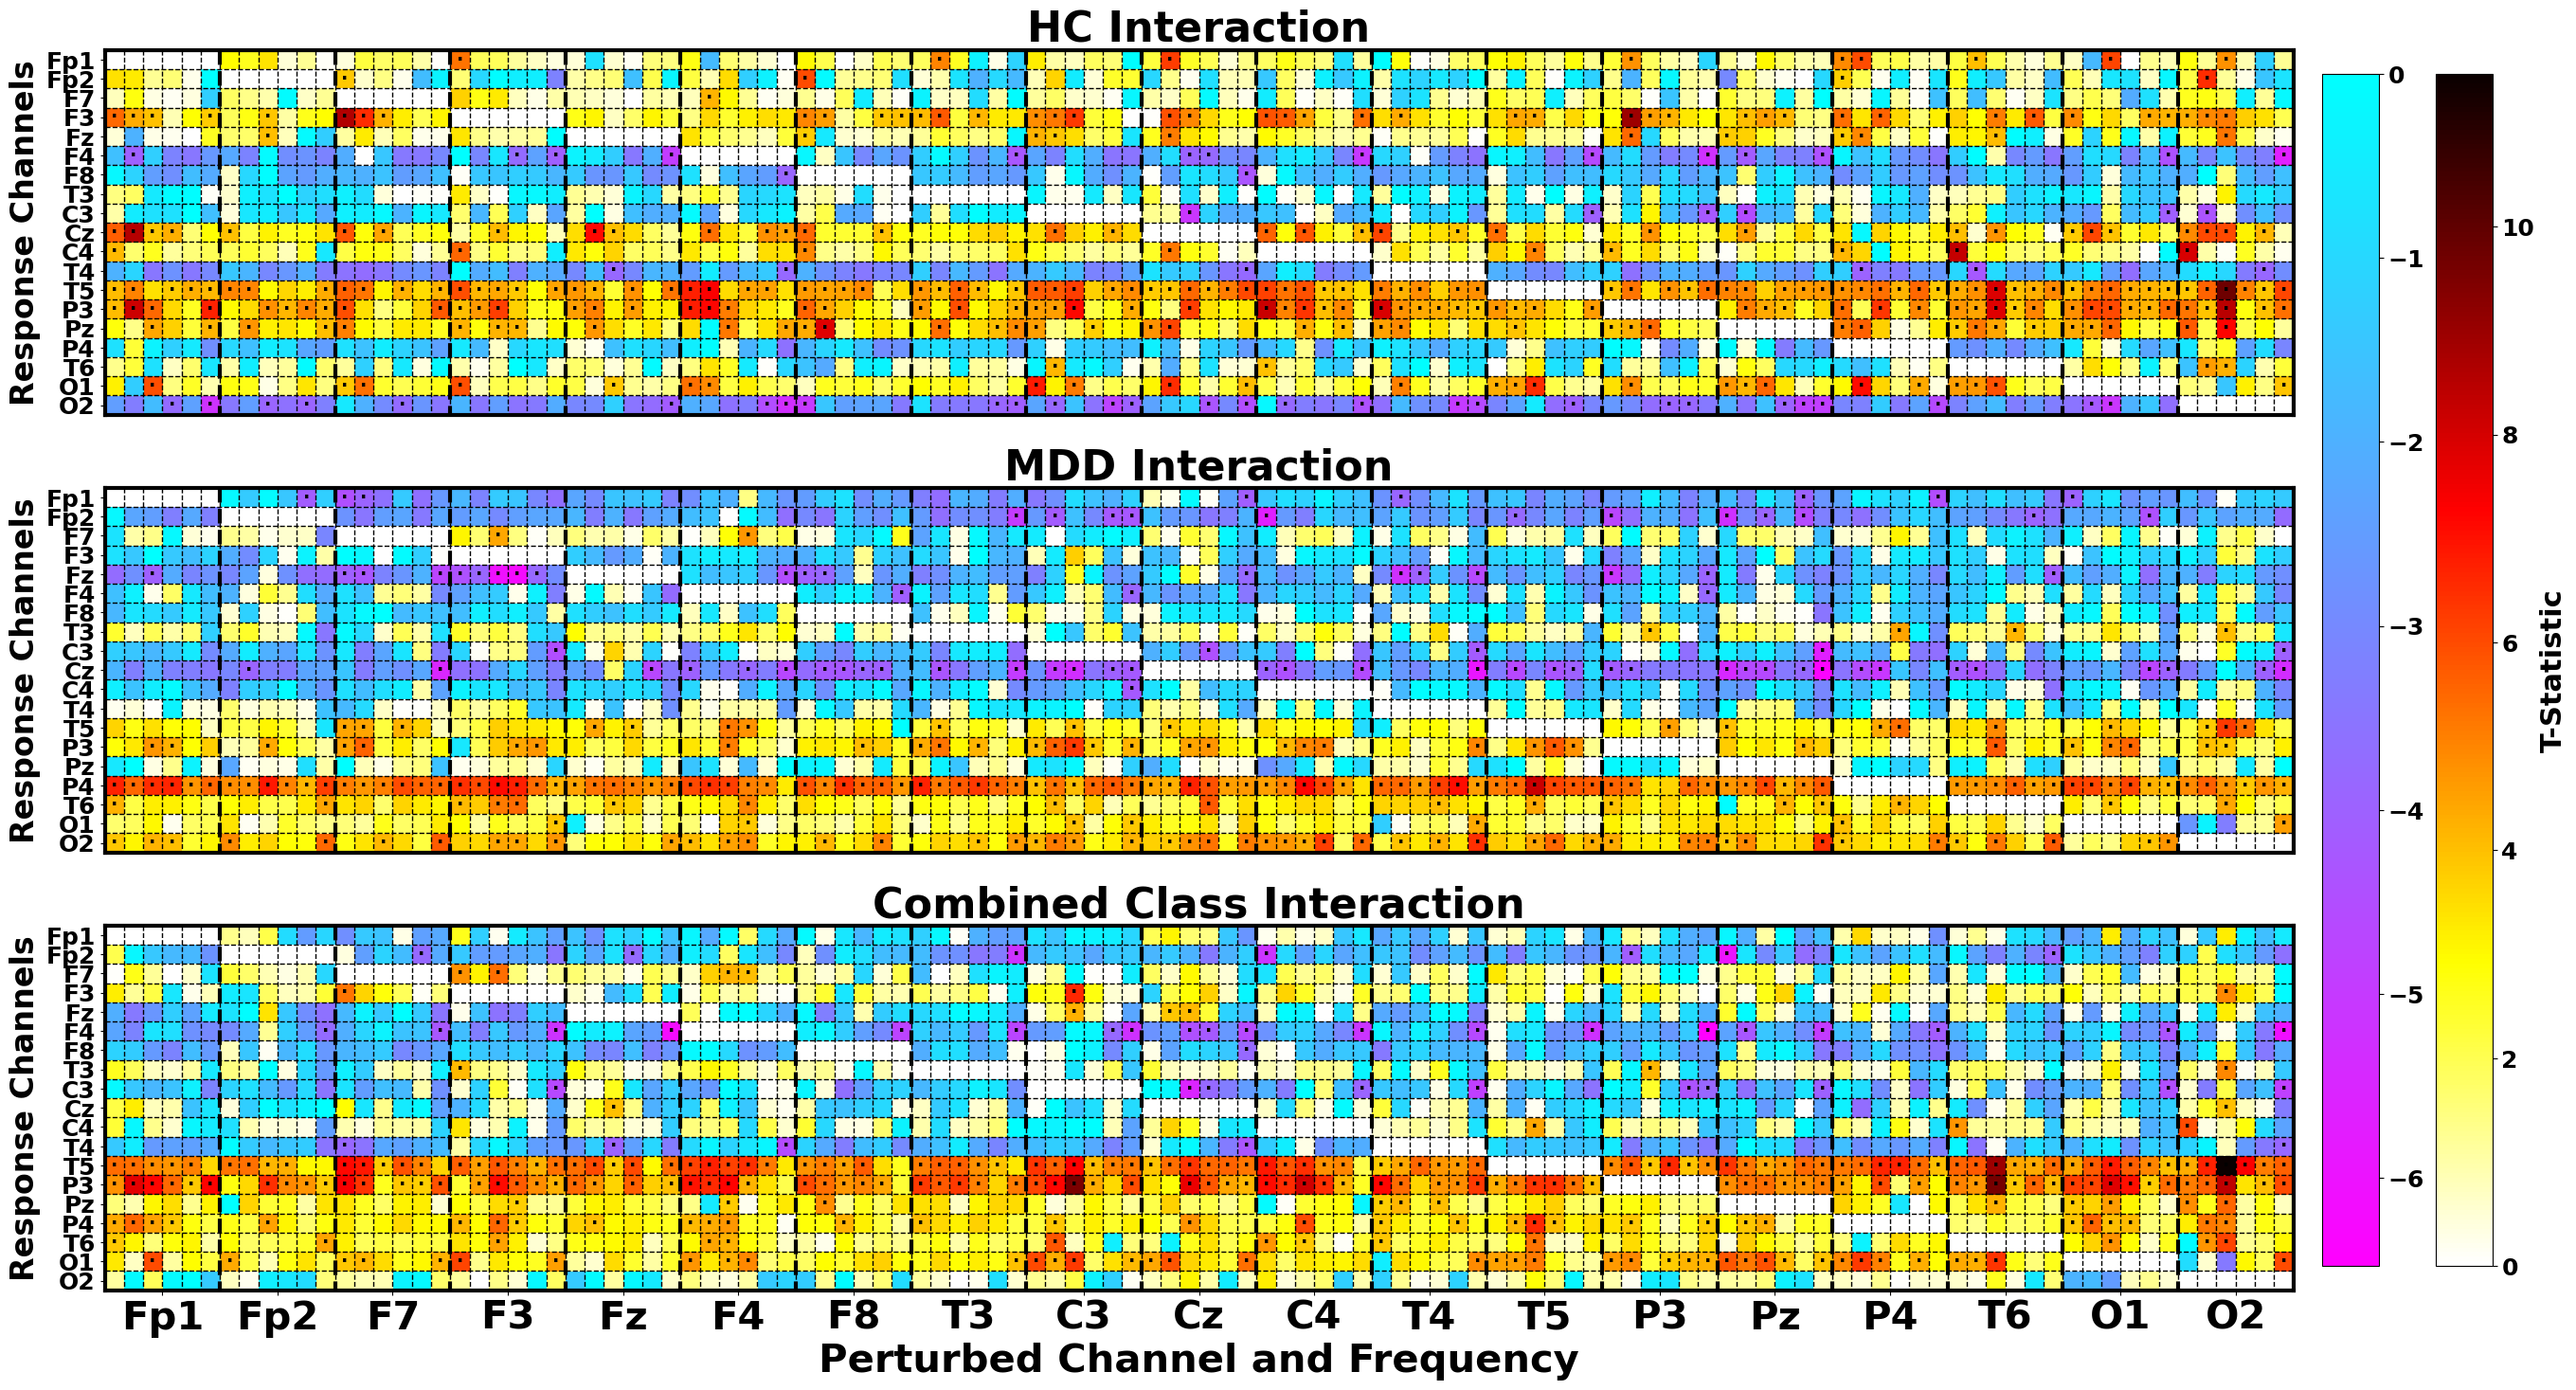

In [15]:
title_vals = ['HC Interaction','MDD Interaction','Combined Class Interaction']
fig, ax = plt.subplots(3,1,figsize=(60,17))
for i in np.arange(3): 
    vals_neg = masked_array(rel_diff_t_features[i,...].T,rel_diff_t_features[i,...].T>np.zeros_like(rel_diff_t_features[i,...].T))
    vals_pos = masked_array(rel_diff_t_features[i,...].T,rel_diff_t_features[i,...].T<np.zeros_like(rel_diff_t_features[i,...].T))
    im = ax[i].imshow(vals_neg,'cool_r',interpolation='nearest',vmin=np.min(rel_diff_t_features),vmax=0,alpha=1)# Reds_r
    im2 = ax[i].imshow(vals_pos,'hot_r',vmin=0,interpolation='nearest',vmax=np.max(rel_diff_t_features),alpha=1)# Reds_r

    ax[i].set_yticks(np.arange(19))
    ax[i].set_yticklabels(channels,fontsize=18,weight='bold');
    ax[i].set_ylabel('Response Channels',fontsize=24,weight='bold')
    ax[i].set_title(title_vals[i],fontsize=32,weight='bold')
    x_idx2 = []
    for j in np.arange(1,19):
        x_idx2.append((j*6)-0.5)
    ax[i].vlines(np.arange(0,114)-0.5,-0.5,18.5,'k','--',linewidth=1)
    ax[i].vlines(x_idx2,-0.5,18.5,'k','--',linewidth=3);
    ax[i].hlines(np.arange(19)-0.5,-0.5,113.5,'k','--',linewidth=1);
    
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(3)
    
    if i == 2:
        x_idx = []
        for x in np.arange(1,20):
            x_idx.append((x*6)-3.5)
        ax[i].set_xticks(x_idx,thickness=2)
        ax[i].set_xticklabels(channels,fontsize=30,weight='bold'); # ,rotation=90
        ax[i].set_xlabel('Perturbed Channel and Frequency',fontsize=30,weight='bold');
    else:
        ax[i].set_xticks([])
        
    corrected_p_values = fdrcorrection(np.ndarray.flatten(rel_diff_p_features[i,:,:].T),alpha=0.001)[1]

    corrected_p_values_reshape = np.reshape(corrected_p_values,(19,114),order='C')
    
    for val1 in range(19):
        for val2 in range(114):
            if corrected_p_values_reshape[val1,val2] < 0.001 and val2 not in np.arange(val1*6,(val1+1)*6): # if below correction threshold and not on diagonal
                ax[i].text(val2,val1-0.25,'.',color='k',ha='center',va='center',weight='bold',fontsize=14)
    
    
# Add Colorbars
fig.subplots_adjust(right=0.9)

cbar_ax1 = fig.add_axes([0.71, 0.125, 0.01, 0.74]) # left bottom width height
cbar_ax2 = fig.add_axes([0.73, 0.125, 0.01, 0.74]) # left bottom width height

cb1 = fig.colorbar(im, cax=cbar_ax1);
plt.setp(cb1.ax.get_yticklabels(),weight='bold',fontsize=18);
cb2 = fig.colorbar(im2, cax=cbar_ax2);
cb2.set_label(label='T-Statistic',weight='bold',fontsize=22)
plt.setp(cb2.ax.get_yticklabels(),weight='bold',fontsize=18);

fig.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Figure7 - SpatioSpectralInteractionPlots_v8.jpg",dpi=600, bbox_inches='tight')

In [16]:
# Reload Results and Select Same-Channel Features
# Load Results
intial_rel = np.squeeze(loadmat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Spectral_Interactions_All_Classes_Fold0_v8.mat')['intial_rel'])
rel_diff_features = np.squeeze(loadmat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Spectral_Interactions_All_Classes_Fold0_v8.mat')['rel_diff_features'])
rel_pct_diff_features = np.squeeze(loadmat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Spectral_Interactions_All_Classes_Fold0_v8.mat')['rel_pct_diff_features'])
rel_diff_t_features = np.squeeze(loadmat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Spectral_Interactions_All_Classes_Fold0_v8.mat')['rel_diff_t_features'])
rel_diff_p_features = np.squeeze(loadmat('C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Spatial_Spectral_Interactions_All_Classes_Fold0_v8.mat')['rel_diff_p_features'])

rel_pct_diff = []
rel_diff = []
rel_diff_t = []
rel_diff_p = []

for i in np.arange(19):
    rel_pct_diff.append(rel_pct_diff_features[:,i*6:(i+1)*6,i])
    rel_diff.append(rel_diff_features[:,i*6:(i+1)*6,i])
    rel_diff_t.append(rel_diff_t_features[:,i*6:(i+1)*6,i])
    rel_diff_p.append(rel_diff_p_features[:,i*6:(i+1)*6,i])
    
rel_pct_diff = np.swapaxes(rel_pct_diff,0,1)
rel_diff = np.swapaxes(rel_diff,0,1)
rel_diff_t = np.swapaxes(rel_diff_t,0,1)
rel_diff_p = np.swapaxes(rel_diff_p,0,1)

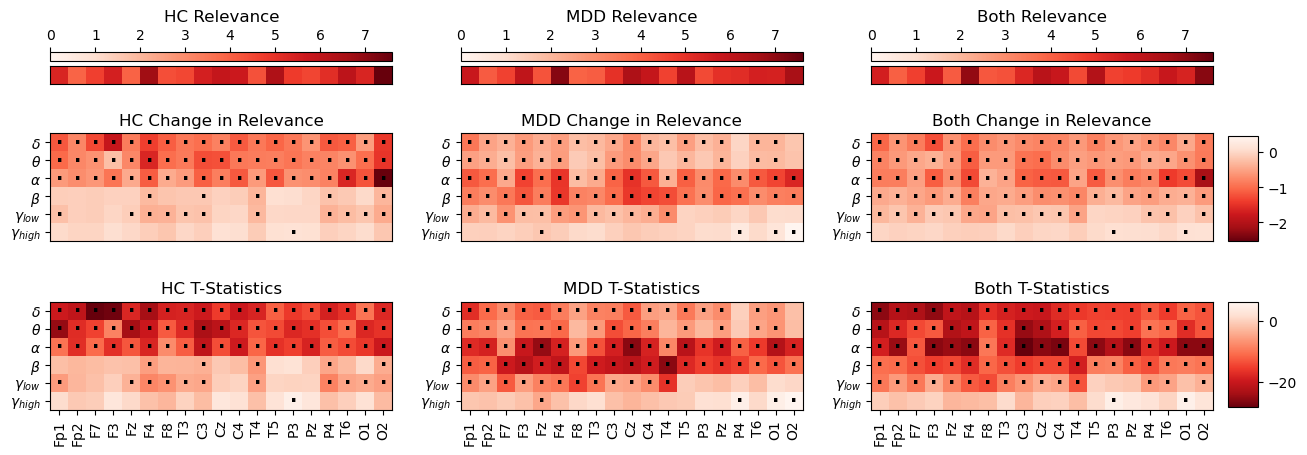

In [17]:
class_val = ['HC','MDD','Both']
fig,ax = plt.subplots(3,3,figsize=(15,5),gridspec_kw={'height_ratios': [1,3,3]})
for class_idx in range(3): #(HC = 0, MDD = 1, Both = 2)
#     plt.subplot(3,2,int(1+class_idx))
    max_val = np.max(initial_rel[:3,...])
    min_val = np.min(initial_rel[:3,...])
    im1 = ax[0,class_idx].imshow(initial_rel[class_idx,:][None],'Reds',vmin = 0,vmax = max_val) # 
    ax[0,class_idx].set_title(class_val[class_idx] + ' Relevance',y=3)
    ax[0,class_idx].set_yticks([])
    ax[0,class_idx].set_xticks([])

    divider = make_axes_locatable(ax[0,class_idx])
    cax = divider.append_axes('top',size='50%',pad=0.05)
    cb = fig.colorbar(im1,cax=cax,orientation='horizontal')
    cax.xaxis.tick_top()
    
    max_val = np.max(rel_diff[:3,...])
    min_val = np.min(rel_diff[:3,...])
    im2 = ax[1,class_idx].imshow(rel_diff[class_idx,...].copy().T,'Reds_r',vmin = min_val,vmax = max_val) # 
    ax[1,class_idx].set_title(class_val[class_idx] + ' Change in Relevance')
    ax[1,class_idx].set_yticks([0,1,2,3,4,5]);
    ax[1,class_idx].set_yticklabels(freq_bands);
    ax[1,class_idx].set_xticks([])

    max_val = np.max(rel_diff_t[:3,...])
    min_val = np.min(rel_diff_t[:3,...])
    im3 = ax[2,class_idx].imshow(rel_diff_t[class_idx,...].copy().T,'Reds_r',vmin = min_val,vmax = max_val)
    ax[2,class_idx].set_title(class_val[class_idx] + ' T-Statistics')
    ax[2,class_idx].set_yticks([0,1,2,3,4,5]);
    ax[2,class_idx].set_yticklabels(freq_bands);
    ax[2,class_idx].set_xticks(np.arange(19));
    ax[2,class_idx].set_xticklabels(channels,rotation=90);
    
    
    corrected_p_values = fdrcorrection(np.ndarray.flatten(rel_diff_p[class_idx,:,:].T),alpha=0.001)[1]

    corrected_p_values_reshape = np.reshape(corrected_p_values,(6,19),order='C')
    
    for val1 in range(6):
        for val2 in range(19):
            if corrected_p_values_reshape[val1,val2] < 0.001: # if below correction threshold and not on diagonal
                ax[1,class_idx].text(val2,val1-0.25,'.',color='k',ha='center',va='center',weight='bold',fontsize=14)
                ax[2,class_idx].text(val2,val1-0.25,'.',color='k',ha='center',va='center',weight='bold',fontsize=14)
    

# Add Colorbars
fig.subplots_adjust(right=0.9)
cbar_ax2 = fig.add_axes([0.91, 0.485, 0.02, 0.21]) # left bottom width height
cb2 = fig.colorbar(im2, cax=cbar_ax2);
cbar_ax3 = fig.add_axes([0.91, 0.152, 0.02, 0.21]) # left bottom width height
cb3 = fig.colorbar(im3, cax=cbar_ax3);

fig.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Figure6 - SpectroSpatial Importance Plots_v8.jpg",dpi=800, bbox_inches='tight')

In [10]:
# import all functions in advance
from numpy import shape, zeros, zeros_like, ones_like, logical_and, squeeze
from numpy.fft import fftfreq, fft, ifft
def LRP_Perturbation_Channel_Freq_Interaction(model,X,Y):
    
    N = np.shape(X)[0]
    Fs = 200 # Sampling Rate
    timestep = 1/Fs # Step Size
    
    # Define Frequency Bins
    bins = [];
    bins.append([0,4]) # delta
    bins.append([4,8]) # theta
    bins.append([8,12]) # alpha
    bins.append([12,25]) # beta
    bins.append([25,45]) # lower gamma
    bins.append([55,100]) # upper gamma
    bins = np.array(bins)
    
    initial_rel = LRP_Output_ab(model,X,Y)
    
    freq = fftfreq(np.shape(X)[1], d=timestep) # 6250 sample frequencies
    
    # Identify Frequency Values Associated with Each Frequency Bin
    bins2 = np.zeros_like(freq) # preallocate array to store marker that identifies bin
    
    for bin_val in range(np.shape(bins)[0]): # for each frequency band
        positive = logical_and(freq>bins[bin_val,0]*np.ones_like(freq),freq<bins[bin_val,1]*np.ones_like(freq)) # indices between positive frequencies
        negative = logical_and(freq<-1*bins[bin_val,0]*np.ones_like(freq),freq>-1*bins[bin_val,1]*np.ones_like(freq)) # indices between negative frequencies
        vals = positive + negative # all samples within bin (OR the arrays)
        bins2[vals] = bin_val*np.ones((np.sum(vals),)) # assign marker to frequency values in each bin
    
    # Perturbation Explainability
    
    rel_diff = zeros((3,int(19*np.shape(bins)[0]),19))
    rel_diff_t = zeros((3,int(19*np.shape(bins)[0]),19))
    rel_diff_p = zeros((3,int(19*np.shape(bins)[0]),19))
    rel_pct_diff = zeros((3,int(19*np.shape(bins)[0]),19))
    
    idx_val = 0
    feature_names = []
    for feature in range(shape(X)[2]): # iterate over each feature

        #perform fft for that channel only
        fft_vals = fft(X[:,:,feature],axis=1);
        mean_vals = np.mean(fft_vals,axis=0) # mean across all samples for each value
        std_vals = np.std(fft_vals,axis=0) # std across all samples fore each value
        
        # Duplicate Time Domain of Samples
        X_2 = X.copy()

        for bin_val in range(np.shape(bins)[0]): # iterate over each frequency band

            # Duplicate Frequency Domain of Samples
            fft_vals2 = fft_vals.copy()

            fft_vals2[:,np.squeeze(list(bins2 == bin_val*ones_like(bins2)))] = zeros_like(fft_vals2[:,np.squeeze(list(bins2 == bin_val*ones_like(bins2)))])

            # Convert Perturbed Samples Back to Time Domain
            feature_ifft = ifft(fft_vals2,axis=1);
            X_2[:,:,feature] = feature_ifft

            after_rel = LRP_Output_ab(model,X_2,Y)
            
            for class_idx in range(3): # iterate over classes (HC = 0, MDD = 1, Both = 2)
                class_ids = squeeze(Y == class_idx*ones_like(Y))
                rel_diff[class_idx,idx_val, :] = np.mean(np.array(after_rel)[class_ids,:] - np.array(initial_rel)[class_ids,:],axis=0)
                rel_diff_t[class_idx,idx_val, :], rel_diff_p[class_idx,idx_val, :] = ttest_rel(np.array(after_rel)[class_ids,:],np.array(initial_rel)[class_ids,:],nan_policy='omit')
                rel_pct_diff[class_idx,idx_val, :] = np.mean((np.array(after_rel)[class_ids,:] - np.array(initial_rel)[class_ids,:]) / np.array(initial_rel)[class_ids,:],axis=0)
                if class_idx == 2:
                    rel_diff[class_idx,idx_val, :] = np.mean(after_rel - initial_rel,axis=0)
                    rel_diff_t[class_idx,idx_val, :], rel_diff_p[class_idx,idx_val, :] = ttest_rel(np.array(after_rel),np.array(initial_rel),nan_policy='omit')
                    rel_pct_diff[class_idx,idx_val, :] = np.mean((after_rel - initial_rel) / initial_rel,axis=0)
            
            idx_val += 1 # iterate over
            feature_names.append('Channel ' + str(feature) + ' Freq ' + str(bin_val))
            print('Channel ' + str(feature) + ' Freq ' + str(bin_val))
            
    initial_rel2 = np.zeros((3,19)) # initial_rel
    for class_idx in range(3): # iterate over classes (HC = 0, MDD = 1, Both = 2)
        initial_rel2[class_idx,:] = np.mean(initial_rel[squeeze(Y == class_idx*np.ones_like(Y)),:],axis=0)
        if class_idx == 2:
            initial_rel2[class_idx,:] = np.mean(initial_rel,axis=0)
            
    return (initial_rel2,rel_diff, rel_pct_diff,feature_names,rel_diff_t,rel_diff_p)

# Temporal Explainability

In [6]:
#LRP Alpha-Beta Rule Implementation - Sums Relevance over Channel Dimension
def LRP_Output_ab_temporal(model,data,class_labels):
    #Strip softmax layer
    model_lrp = innvestigate.utils.model_wo_softmax(model)

    Rel_out = []
    analyzer = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model_lrp,neuron_selection_mode="index")
    Rel_ep = []
    for j in range(np.shape(data)[0]):
        x = data[j,:,:]
        a = analyzer.analyze(x[None], neuron_selection = class_labels[j])
        if j == 0:
            Rel_out = np.abs(a)/np.sum(np.abs(a)) # normalize relevance
        else:
            Rel_out = np.vstack((Rel_out,np.abs(a)/np.sum(np.abs(a))))
        
    return(Rel_out)

In [7]:
## Define Model without Dense Layers

def get_model2(dropout=0.5):
    
    n_timesteps = 5000
    n_features = 19

    convLayer = partial(keras.layers.convolutional.Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=keras.constraints.max_norm(max_value = 1))
    
    model = keras.models.Sequential()
    model.add(convLayer(5, kernel_size=10, strides=1, input_shape=(n_timesteps, n_features), data_format='channels_last'))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(keras.layers.BatchNormalization())

    model.add(convLayer(10, kernel_size=10, strides=1))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(keras.layers.BatchNormalization())
    
    model.add(convLayer(10, kernel_size=10, strides=1))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(keras.layers.BatchNormalization())
    
    model.add(convLayer(15, kernel_size=5, strides=1))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Flatten())
    
    return model

In [9]:
# Get Model that Outputs Extracted Features
model2 = get_model2()
for i in range(len(model2.layers)):
   model2.layers[i].set_weights(model.layers[i].get_weights())

# Extract Features for Test Samples
X_pred = model2.predict(X_test)

In [21]:
# Import Clustering and Dimensionality Reduction Libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

Text(0, 0.5, 'Cummulative Variance Per PC')

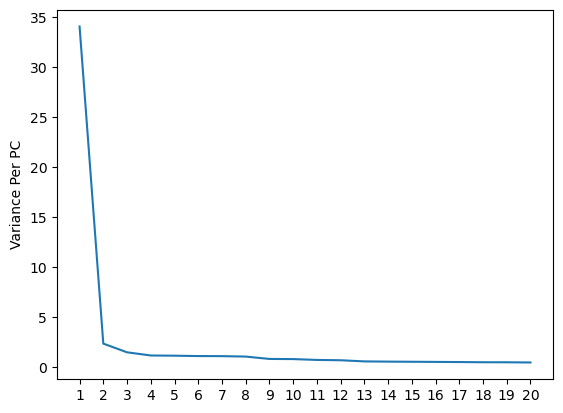

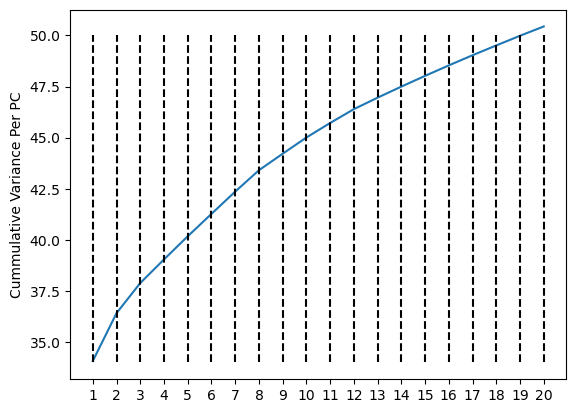

In [11]:
pca = PCA(n_components=20)
values = pca.fit_transform(X_pred)

plt.figure()
plt.plot(np.arange(20)+1,100*pca.explained_variance_ratio_)
plt.xticks(np.arange(20)+1);
plt.ylabel('Variance Per PC')

plt.figure()
plt.plot(np.arange(20)+1,np.cumsum(100*pca.explained_variance_ratio_))
plt.vlines(np.arange(20)+1,34,50,'k','--')
plt.xticks(np.arange(20)+1);
plt.ylabel('Cummulative Variance Per PC')


[0.7099581, 0.5028646, 0.43503234, 0.29398772, 0.24190937, 0.23641205, 0.23140597, 0.21711275, 0.21705851, 0.2721711, 0.22865354, 0.2626245, 0.28414282, 0.3123769, 0.33452716, 0.3572171, 0.36360145, 0.36756483]
[0.7099581, 0.5028646, 0.43503234, 0.29398772, 0.24190937, 0.23641205, 0.23140597, 0.21711275, 0.21705851, 0.2721711, 0.22865354, 0.2626245, 0.28414282, 0.3123769, 0.33452716, 0.3572171, 0.36360145, 0.36756483, 0.7099581, 0.5028646, 0.43503234, 0.29398772, 0.24190937, 0.23641205, 0.23140597, 0.21711275, 0.21705851]


Text(0, 0.5, 'CH Score')

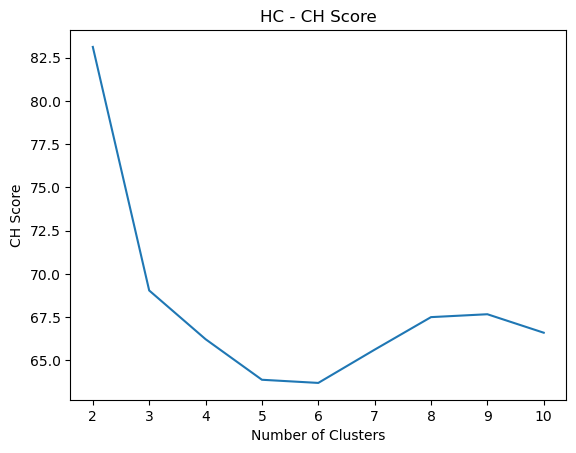

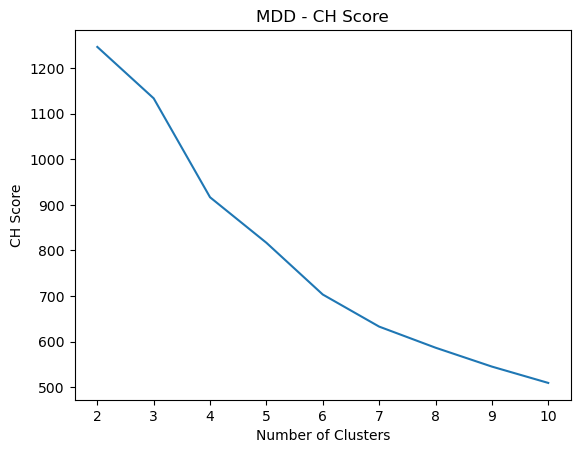

In [31]:
n_components = 8

# Cluster HC Samples
n_clusters = np.arange(2,11)
ch_score = [];

for i in range(2,11):
    kmeans = KMeans(n_clusters=i,n_init=500,random_state=0).fit(values[np.squeeze(y_test==np.zeros_like(y_test)),:n_components]) #np.expand_dims(values[np.squeeze(y_test==np.zeros_like(y_test)),0],axis=1)
    silhouette_vals.append(silhouette_score(values[np.squeeze(y_test==np.zeros_like(y_test)),:n_components],kmeans.labels_))
    db_score.append(davies_bouldin_score(values[np.squeeze(y_test==np.zeros_like(y_test)),:n_components],kmeans.labels_))
    ch_score.append(calinski_harabasz_score(values[np.squeeze(y_test==np.zeros_like(y_test)),:n_components],kmeans.labels_))
    
#     print(i)

print(silhouette_vals)

plt.figure()
plt.plot(n_clusters,ch_score)
plt.title('HC - CH Score')
plt.xlabel('Number of Clusters')
plt.ylabel('CH Score')

# Cluster MDD Samples
n_clusters = np.arange(2,11)
ch_score = [];

for i in range(2,11):
    kmeans = KMeans(n_clusters=i,n_init=500,random_state=0).fit(values[np.squeeze(y_test==np.ones_like(y_test)),:n_components]) 
    silhouette_vals.append(silhouette_score(values[np.squeeze(y_test==np.ones_like(y_test)),:n_components],kmeans.labels_))
    db_score.append(davies_bouldin_score(values[np.squeeze(y_test==np.ones_like(y_test)),:n_components],kmeans.labels_))
    ch_score.append(calinski_harabasz_score(values[np.squeeze(y_test==np.ones_like(y_test)),:n_components],kmeans.labels_))
#     print(i)

print(silhouette_vals)

plt.figure()
plt.plot(n_clusters,ch_score)
plt.title('MDD - CH Score')
plt.xlabel('Number of Clusters')
plt.ylabel('CH Score')

In [23]:
# Recluster HC Samples with Optimal Number of Clusters

n_hc_clusters = 2
kmeans_hc = KMeans(n_clusters=n_hc_clusters,n_init=500,random_state=0).fit(values[np.squeeze(y_test==np.zeros_like(y_test)),:n_components]) # np.expand_dims(values[np.squeeze(y_test==np.zeros_like(y_test)),0],axis=1)

# Recluster MDD Samples with Optimal Number of Clusters
n_mdd_clusters = 2
kmeans_mdd = KMeans(n_clusters=n_mdd_clusters,n_init=500,random_state=0).fit(values[np.squeeze(y_test==np.ones_like(y_test)),:n_components]) # np.expand_dims(values[np.squeeze(y_test==np.ones_like(y_test)),0],axis=1)


In [24]:
# Cluster HC Samples and Get Distance of Each Sample from Their Corresponding Centroids

cluster_dist_hc = KMeans(n_clusters=n_hc_clusters,n_init=500,random_state=0).fit_transform(values[np.squeeze(y_test==np.zeros_like(y_test)),:n_components]) # np.expand_dims(values[np.squeeze(y_test==np.zeros_like(y_test)),0],axis=1)
hc_idx = np.argmin(cluster_dist_hc,axis=0) # Get Index of HC Samples Closest to Cluster Centroids (i.e., Prototype Samples)

hc_samples = X_test[np.squeeze(y_test==np.zeros_like(y_test)),...]
hc_samples = hc_samples[hc_idx,...]

# Cluster MDD Samples and Get Distance of Each Sample from Their Corresponding Centroids

cluster_dist_mdd = KMeans(n_clusters=n_mdd_clusters,n_init=500,random_state=0).fit_transform(values[np.squeeze(y_test==np.ones_like(y_test)),:n_components]) # np.expand_dims(values[np.squeeze(y_test==np.ones_like(y_test)),0],axis=1)
mdd_idx = np.argmin(cluster_dist_mdd,axis=0) # Get Index of MDD Samples Closest to Cluster Centroids (i.e., Prototype Samples)

mdd_samples = X_test[np.squeeze(y_test==np.ones_like(y_test)),...]
mdd_samples = mdd_samples[mdd_idx,...]

# Combine Prototype Samples into One Array and Make Array of Labels
samples = np.vstack((hc_samples,mdd_samples))
samples_labels = [0,0,1,1]

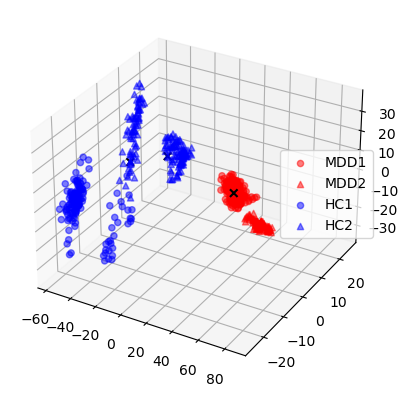

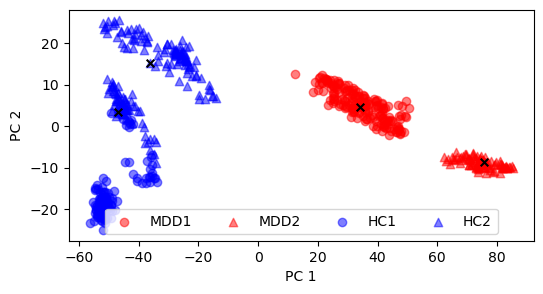

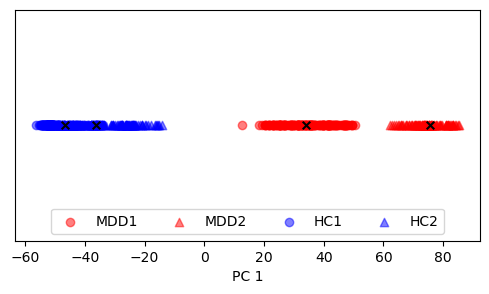

In [27]:
# Plot Results for Dimensionality Reduction-based Clustering
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
mdd_vals = np.squeeze(y_test == np.ones_like(y_test))
hc_vals = np.squeeze(y_test == np.zeros_like(y_test))
marker = ["o","^","s",'.']
for i in range(n_mdd_clusters):
    mdd_vals2 = np.squeeze(kmeans_mdd.labels_==i*np.ones_like(kmeans_mdd.labels_))
    ax.scatter(values[mdd_vals,0][mdd_vals2],values[mdd_vals,1][mdd_vals2],values[mdd_vals,2][mdd_vals2],color = 'r',marker=marker[i],alpha=0.5,label='MDD' + str(int(i+1)))
    
for i in range(n_hc_clusters):
    hc_vals2 = np.squeeze(kmeans_hc.labels_==i*np.ones_like(kmeans_hc.labels_))
    ax.scatter(values[hc_vals,0][hc_vals2],values[hc_vals,1][hc_vals2],values[hc_vals,2][hc_vals2],color = 'b',marker=marker[i],alpha=0.5,label='HC' + str(int(i+1)))
ax.scatter(values[mdd_vals,0][mdd_idx],values[mdd_vals,1][mdd_idx],values[mdd_vals,2][mdd_idx],marker='x',color='k',s=30,alpha=1)
ax.scatter(values[hc_vals,0][hc_idx],values[hc_vals,1][hc_idx],values[hc_vals,2][hc_idx],marker='x',color='k',s=30,alpha=1)
ax.legend(loc='center right')#,weight='bold')
# fig.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Figure8 - PCA Clustering_v2.jpg",dpi=800, bbox_inches='tight')

# Plot Results for Dimensionality Reduction-based Clustering
fig = plt.figure(figsize=(6,3))
mdd_vals = np.squeeze(y_test == np.ones_like(y_test))
hc_vals = np.squeeze(y_test == np.zeros_like(y_test))
marker = ["o","^","s","."]
for i in range(np.shape(mdd_samples)[0]):
    mdd_vals2 = np.squeeze(kmeans_mdd.labels_==i*np.ones_like(kmeans_mdd.labels_))
    plt.scatter(values[mdd_vals,0][mdd_vals2],values[mdd_vals,1][mdd_vals2],color = 'r',marker=marker[i],alpha=0.5,label='MDD' + str(int(i+1)))
    
for i in range(np.shape(hc_samples)[0]):
    hc_vals2 = np.squeeze(kmeans_hc.labels_==i*np.ones_like(kmeans_hc.labels_))
    plt.scatter(values[hc_vals,0][hc_vals2],values[hc_vals,1][hc_vals2],color = 'b',marker=marker[i],alpha=0.5,label='HC' + str(int(i+1)))
plt.scatter(values[mdd_vals,0][mdd_idx],values[mdd_vals,1][mdd_idx],marker='x',color='k',s=30,alpha=1)
plt.scatter(values[hc_vals,0][hc_idx],values[hc_vals,1][hc_idx],marker='x',color='k',s=30,alpha=1)
# plt.yticks([],[])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.ylim([-0.02,0.02])
plt.legend(ncol=5,loc='lower center')#,weight='bold')

# Plot Results for Dimensionality Reduction-based Clustering
fig = plt.figure(figsize=(6,3))
mdd_vals = np.squeeze(y_test == np.ones_like(y_test))
hc_vals = np.squeeze(y_test == np.zeros_like(y_test))
marker = ["o","^","s","."]
for i in range(np.shape(mdd_samples)[0]):
    mdd_vals2 = np.squeeze(kmeans_mdd.labels_==i*np.ones_like(kmeans_mdd.labels_))
    plt.scatter(values[mdd_vals,0][mdd_vals2],np.zeros_like(values[mdd_vals,0][mdd_vals2]),color = 'r',marker=marker[i],alpha=0.5,label='MDD' + str(int(i+1)))
    
for i in range(np.shape(hc_samples)[0]):
    hc_vals2 = np.squeeze(kmeans_hc.labels_==i*np.ones_like(kmeans_hc.labels_))
    plt.scatter(values[hc_vals,0][hc_vals2],np.zeros_like(values[hc_vals,0][hc_vals2]),color = 'b',marker=marker[i],alpha=0.5,label='HC' + str(int(i+1)))
plt.scatter(values[mdd_vals,0][mdd_idx],np.zeros_like(values[mdd_vals,0][mdd_idx]),marker='x',color='k',s=30,alpha=1)
plt.scatter(values[hc_vals,0][hc_idx],np.zeros_like(values[hc_vals,0][hc_idx]),marker='x',color='k',s=30,alpha=1)
plt.yticks([],[])
plt.xlabel('PC 1')
plt.ylim([-0.02,0.02])
plt.legend(ncol=5,loc='lower center')#,weight='bold')
# fig.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Figure8 - PCA Clustering_v8.jpg",dpi=800, bbox_inches='tight')

In [28]:
# Output LRP Results for Each Prototype Sample
samples_lrp = LRP_Output_ab_temporal(model,samples,samples_labels)

In [29]:
# Perform Moving Average on Relevance
import pandas as pd
from scipy.signal import decimate
samples_lrp2 = [];
for i in np.arange(np.shape(samples)[0]):
    samples_lrp2.append(pd.DataFrame(samples_lrp[i,...]).rolling(20,min_periods=1,axis=0).sum().to_numpy())
    
samples_lrp2 = np.array(samples_lrp2)

C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\antho\anaconda3\envs\DeepEnv\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  # This is added back by InteractiveShellApp.init_path()
C:\U

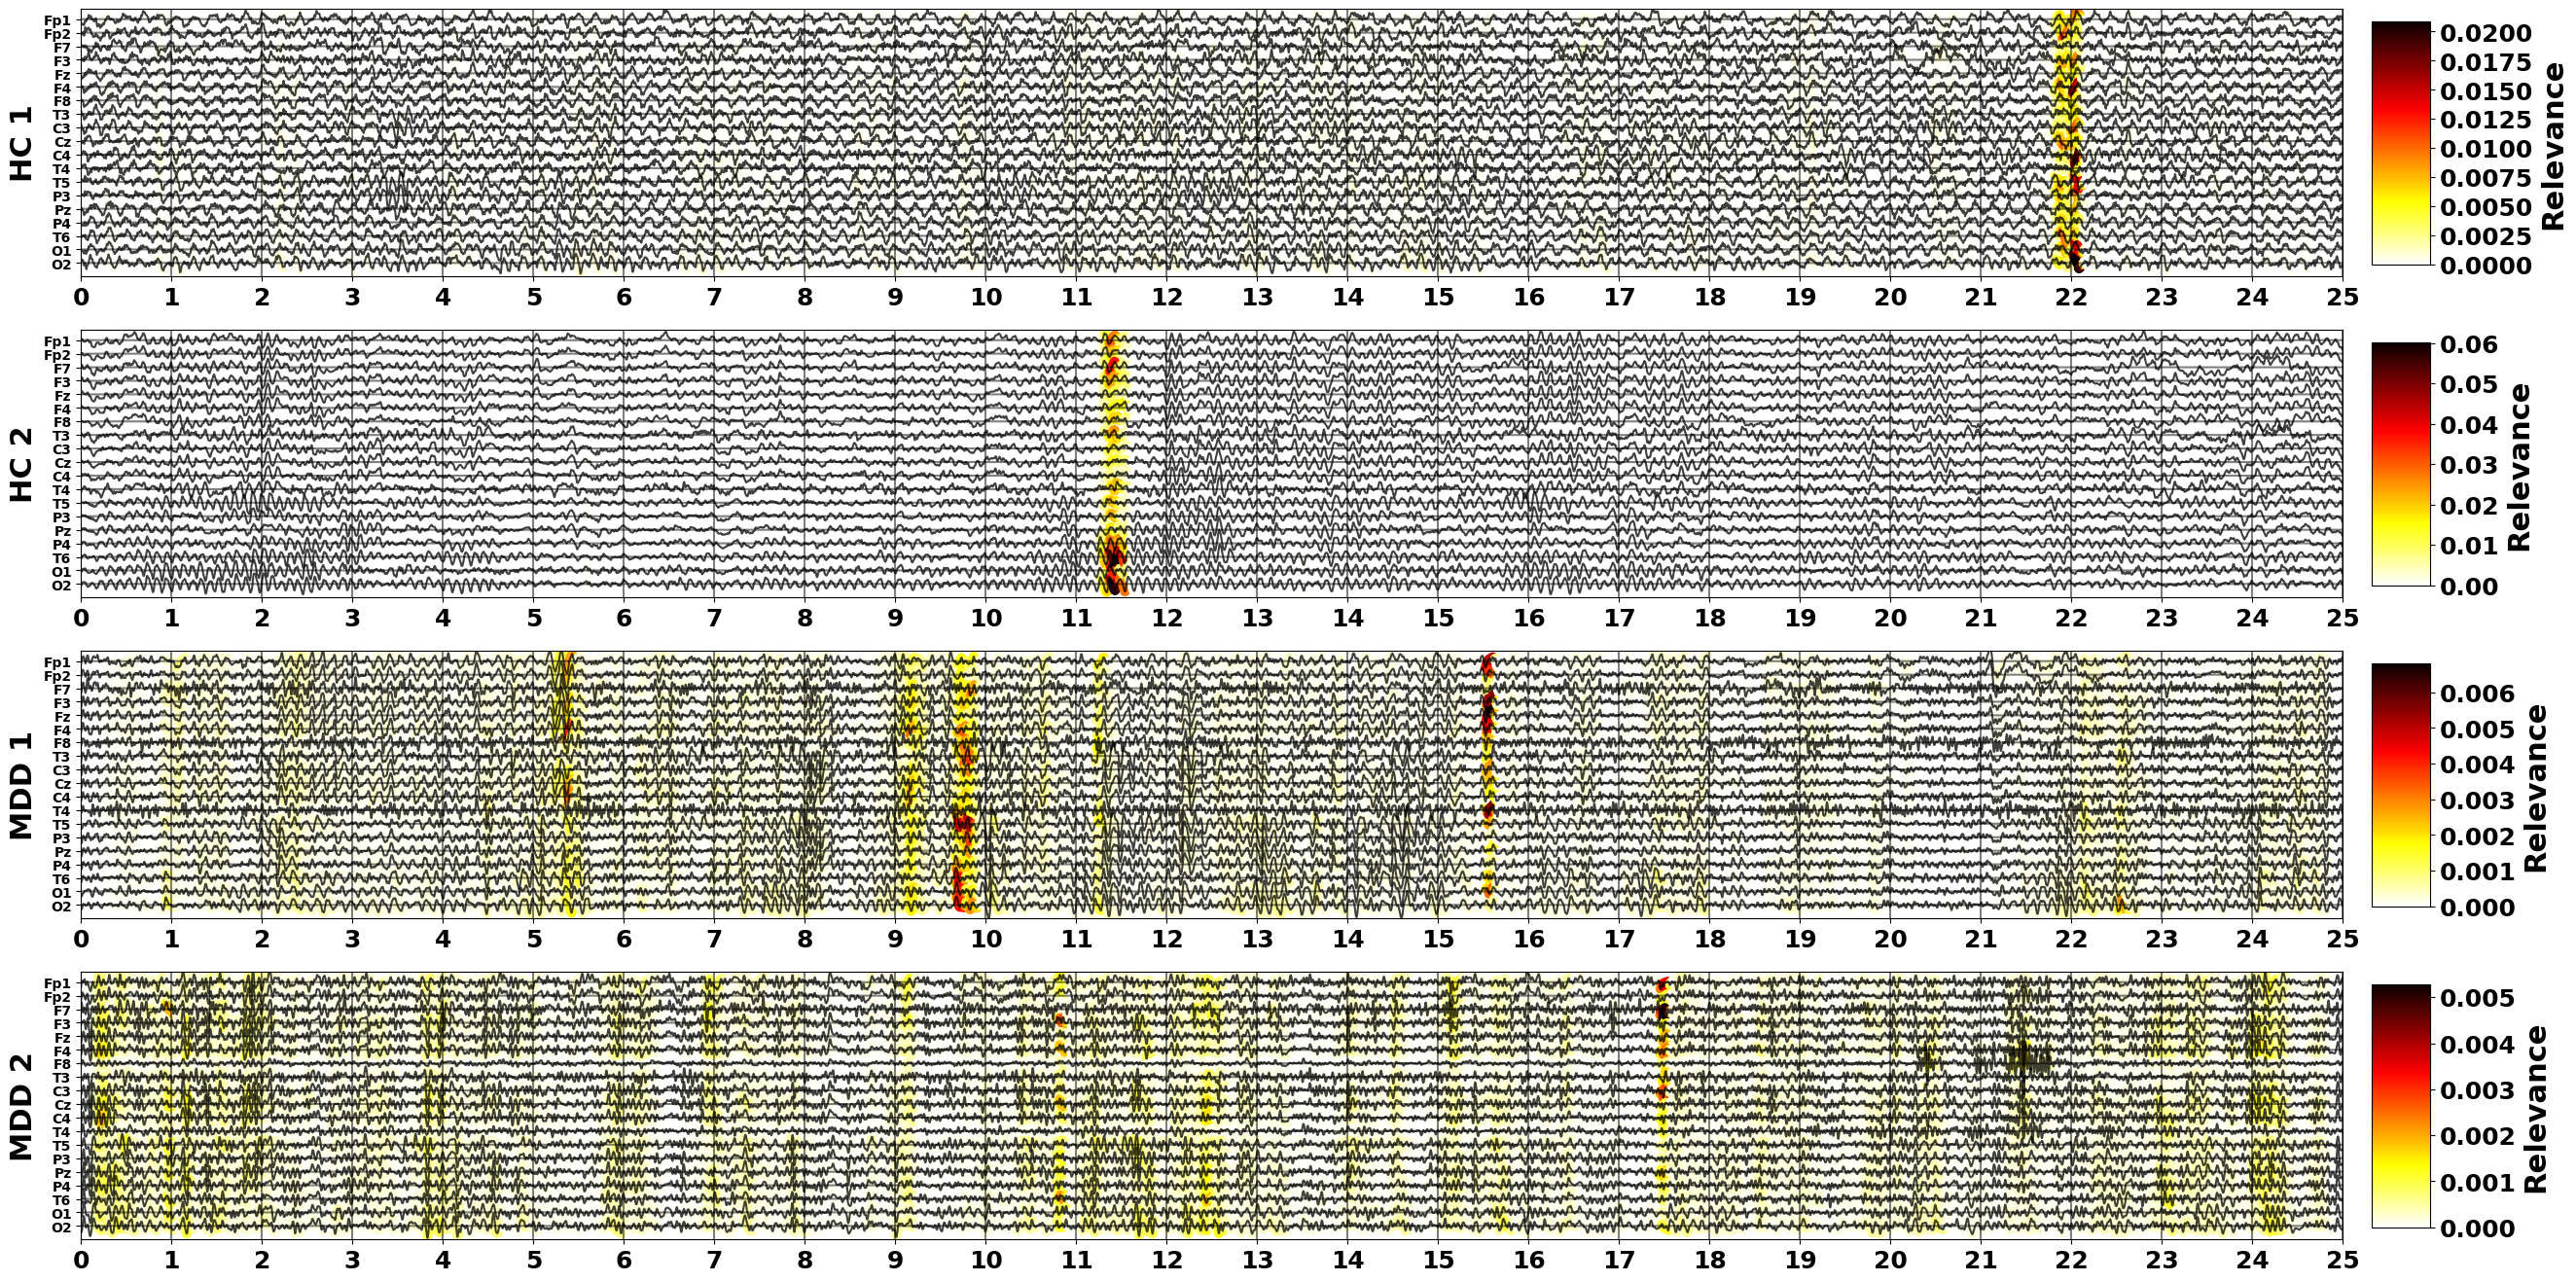

In [30]:
# Plot Prototype Relevance Results
fig = plt.figure(figsize=(30,25))
titles = ['HC 1', 'HC 2', 'MDD 1', 'MDD 2']
for i in range(np.shape(samples)[0]):
    ax = plt.subplot(6,1,i+1)
    vals = samples[i,...]-np.mean(samples[i,...],axis=0)-np.arange(19)*4*np.ones_like(samples[i,...])
    vals2 = -1*np.arange(19)*4*np.ones_like(samples[i,...])
    plt.plot(np.expand_dims(np.arange(5000),axis=1)*np.ones_like(samples[i,...])/200,vals2,'k','..',alpha=0.5)
    plt.plot(np.expand_dims(np.arange(5000),axis=1)*np.ones_like(samples[i,...])/200,vals,'k',alpha=0.75) # 
    plt.vlines(np.arange(26),-76,3,'k',alpha=0.5)
    im = plt.scatter(np.expand_dims(np.arange(5000),axis=1)*np.ones_like(samples[i,...])/200,vals,c=np.array(samples_lrp2[i,...]),cmap = 'hot_r',marker='o', alpha = 1, vmax = np.max(samples_lrp2[i,...])) #cool

#     im = plt.scatter(np.expand_dims(np.arange(250),axis=1)*np.ones_like(samples_lrp2[i,...])/10,decimate(vals,q=20,axis=0),c=np.array(samples_lrp2[i,...]),cmap = 'hot_r',marker='o', alpha = 1, vmax = np.max(samples_lrp2)) #cool
    plt.yticks(-4*np.arange(19),channels,weight='bold')
    plt.xticks(np.arange(26),weight='bold',fontsize=18)

    if i == 4:
        plt.xlabel('Time (sec)',weight='bold',fontsize=18)
    plt.ylabel(titles[i],weight='bold',fontsize=22)
    
    plt.ylim([-76,3])
    plt.xlim([0,5000/200])
#     plt.colorbar()
    
    # Add Colorbars
    fig.subplots_adjust(right=0.9)
    
    if i == 0:
#         print(i)
        cbar_ax1 = fig.add_axes([0.91, 0.775, 0.02, 0.1]) # left bottom width height
    elif i == 1:
        cbar_ax1 = fig.add_axes([0.91, 0.643, 0.02, 0.1]) # left bottom width height
    elif i == 2:
        cbar_ax1 = fig.add_axes([0.91, 0.511, 0.02, 0.1]) # left bottom width height
    elif i == 3:
        cbar_ax1 = fig.add_axes([0.91, 0.379, 0.02, 0.1]) # left bottom width height
    elif i == 4:
        cbar_ax1 = fig.add_axes([0.91, 0.247, 0.02, 0.1]) # left bottom width height


    cb1 = fig.colorbar(im, cax=cbar_ax1);
    plt.setp(cb1.ax.get_yticklabels(),weight='bold',fontsize=18);
    cb1.set_label(label='Relevance',weight='bold',fontsize=22)

# fig.savefig("C:/Users/antho/Documents/Calhoun_Lab/Projects/Spectral_Explainability/MDD/Journal/Figure9 - Temporal Importance_v8.jpg",dpi=600, bbox_inches='tight')